# Preparing the velocity model to use NLLoc

This notebook does some computations on a velocity model and put it in a netdcf format that will be used in the SimulPS_Vel2Grid_v2 notebook. The only interpolation done here is for the depths, and the dimensions of the model stay the same. All the work on the model is made for a 3D velocity model.

Watch out for !!, TO-DO, ###.

#### 3rd version of this notebook:

- No interpolation in degrees for lat/lon, only in km for depths
- Doesn't save a subset of the model in netdcf but all of it 

In [22]:
import math
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from scipy import interpolate
base_dir = '/Users/lpapin/Documents/phd/projects/sw4/nonlinloc/'

## Prepare the velocity model

### Load the data + some calculations

First, getting the locations of the events and the stations, that will give us the boundaries of the region. From that, I get the boundaries of a subset model gathering all events and stations. The limits will help deifne the projection in the Cartesian system, then the interpolation in SimulPS_Vel2Grid.ipynb. 

In [2]:
# Load LFE data on Bostock's catalog
events = pd.read_csv('lfe_svi.txt', index_col=0, dtype={'date': str, 'hour': str, 'lfe_family' : str})
events['date'] = '20' + events['date']
events['date'] = pd.to_datetime(events['date'], format='%Y%m%d')
events['hour'] = events['hour'].str.zfill(2)
events['OT'] = events['date'] + pd.to_timedelta(events['hour'].astype(int), unit='h') + pd.to_timedelta(events['second'], unit='s')
events = events.drop(columns=['hour','second'])
events = events.sort_values(by='OT', ascending=True)
events.reset_index(inplace=True)
events.index.name = 'Index'
print(events)
# Load the locations ###Bostock or Tim's locations idk
sav_family_phases = np.load('sav_family_phases.npy', allow_pickle=True).item()

       lfe_family       date     Mw                      OT
Index                                                      
0             045 2003-02-26  1.513 2003-02-26 00:15:02.050
1             132 2003-02-26  1.516 2003-02-26 00:49:42.850
2             032 2003-02-26  1.516 2003-02-26 01:27:25.575
3             032 2003-02-26  1.583 2003-02-26 01:28:08.375
4             066 2003-02-26  1.850 2003-02-26 01:47:36.225
...           ...        ...    ...                     ...
269418        078 2013-10-13  1.150 2013-10-13 14:30:58.400
269419        275 2013-10-13  1.352 2013-10-13 15:01:46.800
269420        263 2013-10-13  1.360 2013-10-13 15:04:50.000
269421        256 2013-10-13  1.127 2013-10-13 21:20:43.325
269422        295 2013-10-13  1.771 2013-10-13 23:59:29.725

[269423 rows x 4 columns]


In [3]:
# Get the families and match the locations
nb_family = events['lfe_family'].unique()
nb_family.sort()
eventLocs = []
for fam in nb_family:
    eqLoc_values = sav_family_phases[fam]['eqLoc']
    lon_family, lat_family, z_family = eqLoc_values
    lon_family = lon_family * -1
    eventLocs.append([fam, lon_family, lat_family, z_family])
eventLocs = pd.DataFrame(eventLocs, columns=['Index', 'lon', 'lat', 'depth'])
eventLocs.set_index('Index', inplace=True) ###index=family
print(eventLocs)

              lon        lat  depth
Index                              
001   -123.912333  48.418833  32.66
002   -123.588667  48.421833  34.97
003   -123.519667  48.185167  30.08
005   -123.800667  48.479667  34.97
006   -123.940000  48.458333  32.15
...           ...        ...    ...
296   -123.481500  48.392167  37.05
297   -123.528333  48.401667  33.92
298   -123.666833  48.814167  42.18
299   -123.875833  48.872833  40.52
300   -123.921167  48.513000  32.94

[130 rows x 3 columns]


In [4]:
# Get the stations locations
stas=pd.read_csv('stations.csv', usecols=[1, 2, 3, 4],
                    names=['sta', 'lat', 'lon', 'elev'], header=0, delimiter='|')
# Matching the stations with the one used in the picker
stations_to_keep = {'SSIB', 'SILB', 'TSJB', 'TWKB', 'KLNB', 'LZB', 'PGC', 'PFB', 'MGCB', 'NLLB', 'SNB', 'YOUB'}
stas = stas[stas['sta'].isin(stations_to_keep)].reset_index(drop=True)
print(stas)

     sta      lat       lon   elev
0   MGCB  48.6317 -123.6808  236.0
1    LZB  48.6122 -123.8240  794.0
2   NLLB  49.2271 -123.9882  199.0
3    PFB  48.5747 -124.4541  449.0
4    PGC  48.6498 -123.4521   12.0
5    SNB  48.7751 -123.1723  402.0
6   YOUB  48.9010 -124.2618  771.0
7   KLNB  48.6611 -123.5706    0.0
8   SILB  48.6020 -123.2815   76.0
9   SSIB  48.7558 -123.3875   12.0
10  TSJB  48.6013 -123.9885  378.0
11  TWKB  48.6448 -123.7332  128.0


### Plot the events and stations + get the boundaries

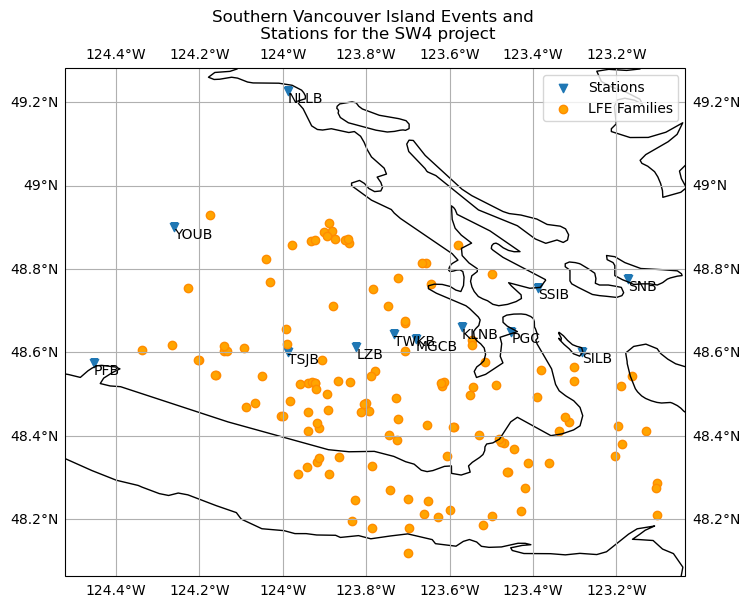

In [5]:
# Plotting the families and the stations
fig=plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(stas['lon'],stas['lat'],marker='v',label='Stations')
[plt.text(i, j, f'{name}',va='top',ha='left') for (i, j,name) in zip(stas['lon'],stas['lat'],stas['sta'])]
plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='LFE Families')
ax.legend()
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
plt.title('Southern Vancouver Island Events and \n Stations for the SW4 project')
#plt.savefig(base_dir+'map_evsta_SVI.png', dpi=300)
plt.show()

In [6]:
# Gets the limits of the rectangle that encompasses all of our points plus a little buffer
Plotlims=ax.get_extent()
lonMin_ini, lonMax_ini, latMin_ini, latMax_ini=Plotlims
print(f'{lonMin_ini:.2f}, {lonMax_ini:.2f}, {latMin_ini:.2f}, {latMax_ini:.2f}')

-124.52, -123.03, 48.06, 49.28


### Load the velocity model

In [7]:
# Define latitude, longitude, and depth ranges for the grid
latMin, latMax, lonMin, lonMax = 48, 49.3, -124.5, -123
# Load the model and get a subset
velmodel=pd.read_csv('Savard_VpVs.txt', sep='\s+',header=None, names=['lon', 'lat', 'depth', 'vp', 'vs', 'DWS'])
velmodel = velmodel.drop(columns=['DWS'])
print(velmodel, '\nbecomes')
velmodel_subset=velmodel[(velmodel['lat']>=latMin)&(velmodel['lat']<=latMax)&(velmodel['lon']<=lonMax)&(velmodel['lon']>=lonMin)]
print(velmodel_subset)

              lon        lat  depth        vp        vs
0     -126.672510  46.951514    0.0  4.956299  2.864755
1     -126.675741  47.077409    0.0  4.966347  2.870762
2     -126.678979  47.203304    0.0  4.976305  2.876411
3     -126.681999  47.320203    0.0  4.968136  2.871618
4     -126.685262  47.446098    0.0  4.957817  2.865878
...           ...        ...    ...       ...       ...
36987 -120.554069  50.494531   93.0  8.245674  4.766323
36988 -120.549634  50.620422   93.0  8.249911  4.768947
36989 -120.545500  50.737325   93.0  8.257427  4.772954
36990 -120.541032  50.863220   93.0  8.261029  4.774880
36991 -120.536556  50.989115   93.0  8.264282  4.776913

[36992 rows x 5 columns] 
becomes
              lon        lat  depth        vp        vs
417   -124.486230  48.057585    0.0  4.015196  2.321009
418   -124.486825  48.183476    0.0  3.422538  1.978356
419   -124.487386  48.300378    0.0  3.399979  1.965315
420   -124.487988  48.426274    0.0  4.170433  2.434671
421   -124.48

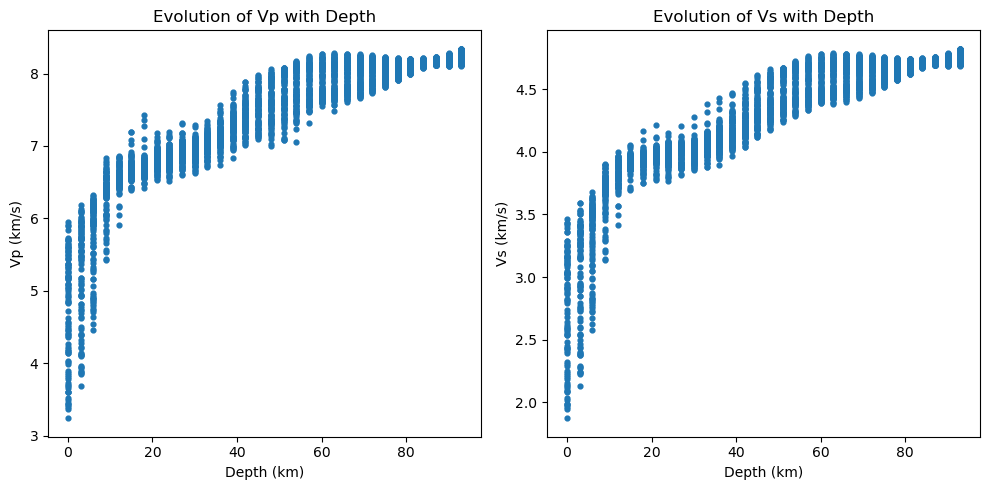

In [30]:
# How the velocities varies with the depth
df = velmodel_subset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(df['depth'], df['vp'], s=12)
ax1.set_xlabel('Depth (km)')
ax1.set_ylabel('Vp (km/s)')
ax1.set_title('Evolution of Vp with Depth')
ax2.scatter(df['depth'], df['vs'], s=12)
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Vs (km/s)')
ax2.set_title('Evolution of Vs with Depth')
plt.tight_layout()
plt.show()

Note that the depths are going every 3km from 0 to 93km (32 values).

In [9]:
# Maximum and minimum velocities
print(f"The minimum Vp is {np.min(velmodel_subset['vp']):.2f} km/s and the maximum is {np.max(velmodel_subset['vp']):.2f} km/s.")
print(f"The minimum Vs is {np.min(velmodel_subset['vs']):.2f} km/s and the maximum is {np.max(velmodel_subset['vs']):.2f} km/s.")

The minimum Vp is 3.24 km/s and the maximum is 8.34 km/s.
The minimum Vs is 1.87 km/s and the maximum is 4.82 km/s.


### Interpolation of the velocity model grid

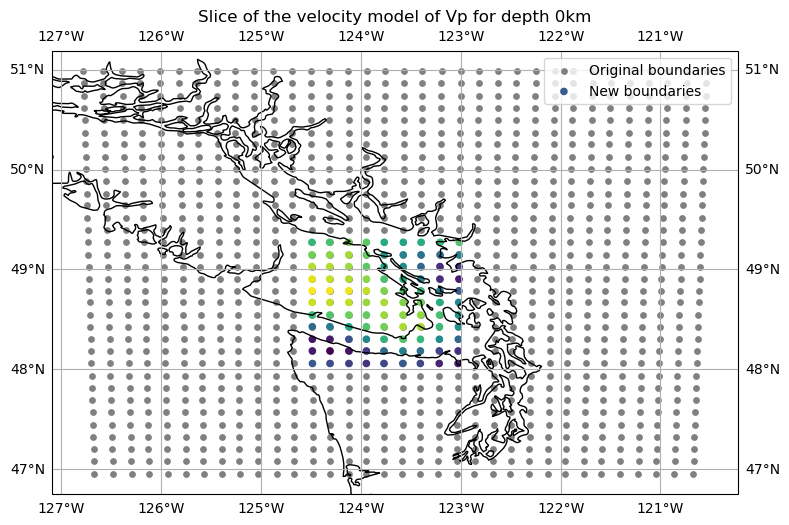

In [10]:
# Example of a slice interpolation ###make it better but works
d=0#depth of the slice
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
dslice=velmodel[velmodel['depth']==d]
plt.scatter(dslice['lon'],dslice['lat'],15,'grey', label="Original boundaries")
dslice_subset=velmodel_subset[velmodel_subset['depth']==d]
plt.scatter(dslice_subset['lon'],dslice_subset['lat'],20,dslice_subset['vp'],label="New boundaries")
ax.legend()
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
plt.title(f"Slice of the velocity model of Vp for depth {d}km")
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig(base_dir+f'slice_{d}km.png', dpi=300)
plt.show()

Some approximations for the polygon in SimulPS_Vel2Grid notebook. The values are needed in the create_dict_std_param fct.

In [11]:
# Variables of reference
lat_mid = (latMin+latMax)/2 
km_per_degree_lat = 111

# Calculate the distance in latitude (in km)
degrees_step_lat = velmodel_subset['lat'].iloc[1]-velmodel_subset['lat'].iloc[0]
latitude_distance_km = (latMax - latMin) * km_per_degree_lat

# Calculate the distance in longitude (in km) at the midpoint latitude
degrees_step_lon = np.abs(velmodel_subset['lon'].iloc[1])-np.abs(velmodel_subset['lon'].iloc[0])
longitude_distance_km = (lonMax - lonMin) * math.cos(math.radians(lat_mid)) * km_per_degree_lat

# Output the results for polygon
print(f"Distance between latitudes: {latitude_distance_km:.2f} km (for ymin and ymax)")
print(f"Distance between longitudes: {longitude_distance_km:.2f} km (for xmin and xmax)")

Distance between latitudes: 144.30 km (for ymin and ymax)
Distance between longitudes: 110.00 km (for xmin and xmax)


#### Interpolation of the depths

This part gives a step of 1km for the depths instead of 3, and adds 1km of elevation to take into account the stations. 

In [12]:
# Pivot the DataFrame to better work on it
df_pivot = velmodel.pivot_table(index=['lat', 'lon', 'depth'], values=['vp', 'vs'])

# Change the depths values (z positive)
depth_min = -1
depth_max = 93
ds = xr.Dataset.from_dataframe(df_pivot).sel(depth=slice(depth_min, depth_max)).reindex({"depth": range(depth_min, depth_max+1)})

# Interpolate to have values on each slices in depth
ds_interp = ds.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
ds_interp

<xarray.Dataset> Size: 60MB
Dimensions:  (lat: 34, lon: 1156, depth: 95)
Coordinates:
  * lat      (lat) float64 272B 46.95 47.08 47.2 47.32 ... 50.74 50.86 50.99
  * lon      (lon) float64 9kB -126.8 -126.8 -126.8 ... -120.5 -120.5 -120.5
  * depth    (depth) int64 760B -1 0 1 2 3 4 5 6 7 ... 86 87 88 89 90 91 92 93
Data variables:
    vp       (lat, lon, depth) float64 30MB nan nan nan ... 8.214 8.264 8.264
    vs       (lat, lon, depth) float64 30MB nan nan nan ... 4.748 4.777 4.777

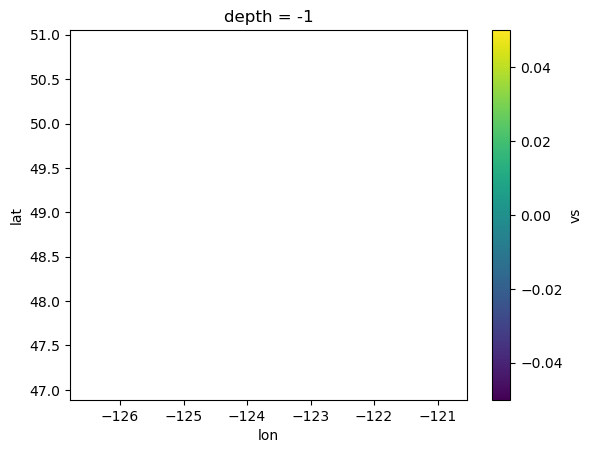

In [13]:
ds.sel(depth=depth_min).vs.plot()

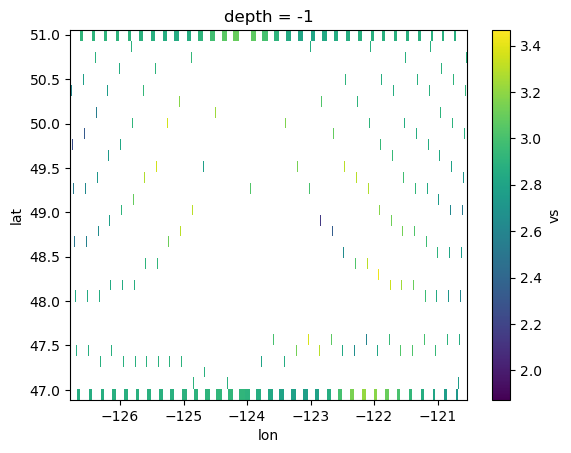

In [14]:
ds_interp.sel(depth=depth_min).vs.plot()

# Interpolation by depth slice to fill gaps

In [20]:
def interp_depth_slice(depth_data, lon, lat, method='cubic'):
    """
    Interpolates missing data for a specific depth using scipy's griddata.

    Parameters:
    depth_data (np.array): 2D array of data at a specific depth.
    lon (np.array): 1D array of longitudes.
    lat (np.array): 1D array of latitudes.
    method (str): Interpolation method (default is 'cubic').

    Returns:
    np.array: 2D array of interpolated data.
    """
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    
    # Mask to get the valid data points
    mask = ~np.isnan(depth_data)
    
    # Coordinates of the valid data points
    points = np.column_stack((lon_grid[mask], lat_grid[mask]))
    
    # Values of the valid data points
    values = depth_data[mask]
    
    # Coordinates for the entire grid
    grid_points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
    
    # Perform the interpolation
    interpolated_data = interpolate.griddata(points, values, grid_points, method=method)
    
    return interpolated_data.reshape(depth_data.shape)

def apply_interpolation(xr_data, method='cubic'):
    """
    Applies interpolation to an xarray DataArray along the depth dimension.

    Parameters:
    xr_data (xr.DataArray): xarray DataArray with dimensions (lon, lat, depth).
    method (str): Interpolation method (default is 'cubic').

    Returns:
    xr.DataArray: Interpolated xarray DataArray.
    """
    # Get the coordinates
    lon = xr_data['lon'].values
    lat = xr_data['lat'].values

    # Use xarray's apply_ufunc to apply the interpolation function to each depth slice
    interpolated = xr.apply_ufunc(
        interp_depth_slice,
        xr_data,
        input_core_dims=[['lat', 'lon']],
        output_core_dims=[['lat', 'lon']],
        vectorize=True,
        dask='parallelized',
        kwargs={'lon': lon, 'lat': lat, 'method': method}
    )
    
    return interpolated

In [21]:
ds_interp['vp_interp'] = apply_interpolation(ds_interp.vp, method='cubic')
ds_interp['vs_interp'] = apply_interpolation(ds_interp.vs, method='cubic')
velmodel_interp=ds_interp

### Save the model

In [17]:
# Keep the interpolated one
velmodel_interp.to_netcdf("velmodel_interp.nc")
velmodel_interp

<xarray.Dataset> Size: 119MB
Dimensions:    (lat: 34, lon: 1156, depth: 95)
Coordinates:
  * lat        (lat) float64 272B 46.95 47.08 47.2 47.32 ... 50.74 50.86 50.99
  * lon        (lon) float64 9kB -126.8 -126.8 -126.8 ... -120.5 -120.5 -120.5
  * depth      (depth) int64 760B -1 0 1 2 3 4 5 6 7 ... 86 87 88 89 90 91 92 93
Data variables:
    vp         (lat, lon, depth) float64 30MB nan nan nan ... 8.214 8.264 8.264
    vs         (lat, lon, depth) float64 30MB nan nan nan ... 4.748 4.777 4.777
    vp_interp  (depth, lat, lon) float64 30MB nan nan nan ... 8.264 8.264 8.264
    vs_interp  (depth, lat, lon) float64 30MB nan nan nan ... 4.777 4.777 4.777

# A look at the subset velocities (before interpolation on depths)

In [18]:
# Let's look at our original velocities
velocities = velmodel_subset.groupby('depth').agg(
    max_vp=('vp', 'max'),
    min_vp=('vp', 'min'),
    mean_vp=('vp', 'mean'),
    median_vp=('vp', 'median'),
    max_vs=('vs', 'max'),
    min_vs=('vs', 'min'),
    mean_vs=('vs', 'mean'),
    median_vs=('vs', 'median')
).reset_index()
velocities = velocities.round(2)

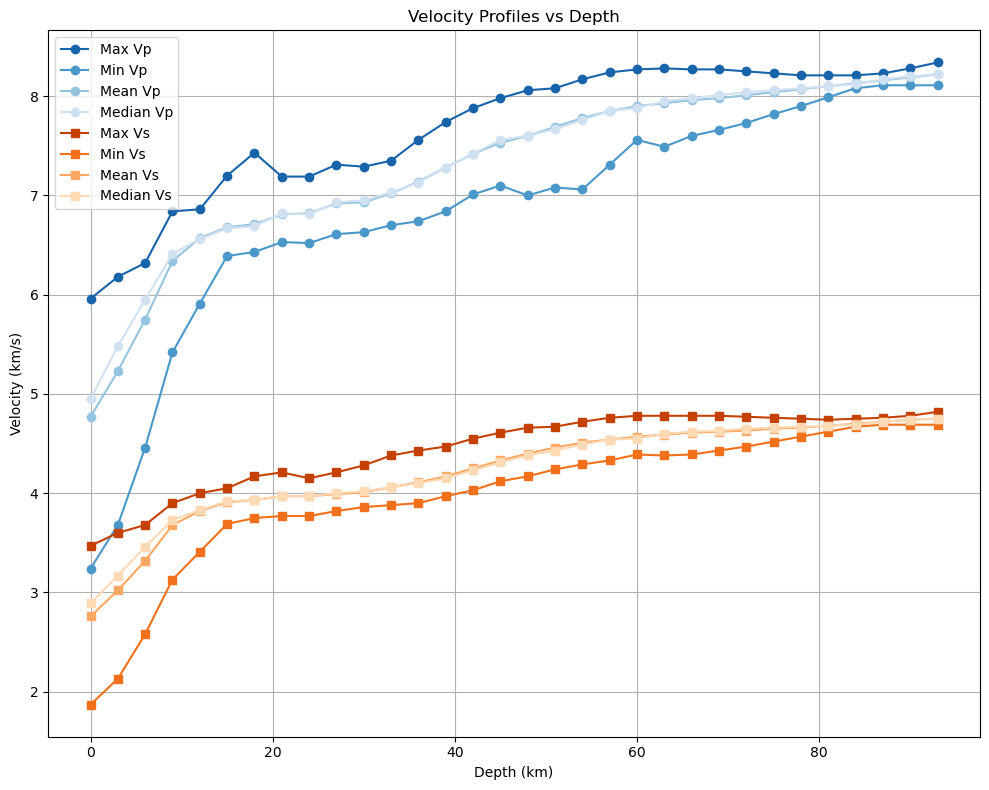

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
vp_colors = matplotlib.colormaps['Blues']
vs_colors = matplotlib.colormaps['Oranges']
ax.plot(velocities['depth'], velocities['max_vp'], label='Max Vp', marker='o', color=vp_colors(0.8))
ax.plot(velocities['depth'], velocities['min_vp'], label='Min Vp', marker='o', color=vp_colors(0.6))
ax.plot(velocities['depth'], velocities['mean_vp'], label='Mean Vp', marker='o', color=vp_colors(0.4))
ax.plot(velocities['depth'], velocities['median_vp'], label='Median Vp', marker='o', color=vp_colors(0.2))
ax.plot(velocities['depth'], velocities['max_vs'], label='Max Vs', marker='s', color=vs_colors(0.8))
ax.plot(velocities['depth'], velocities['min_vs'], label='Min Vs', marker='s', color=vs_colors(0.6))
ax.plot(velocities['depth'], velocities['mean_vs'], label='Mean Vs', marker='s', color=vs_colors(0.4))
ax.plot(velocities['depth'], velocities['median_vs'], label='Median Vs', marker='s', color=vs_colors(0.2))
ax.set_xlabel('Depth (km)')
ax.set_ylabel('Velocity (km/s)')
ax.set_title('Velocity Profiles vs Depth')
ax.legend()
ax.grid(True)
plt.tight_layout()
#plt.savefig(base_dir+'vpvs_profiles_vs_depth.png', dpi=300)
plt.show()